# Forecasting AI and ML Job Trends with SARIMA

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import kagglehub

## Dataset

In [2]:
path = kagglehub.dataset_download("asaniczka/1-3m-linkedin-jobs-and-skills-2024")
print("Path to dataset files:", path)

Path to dataset files: /Users/mzitoh/.cache/kagglehub/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024/versions/2


In [3]:
file_names = ["job_skills.csv", "job_summary.csv", "linkedin_job_postings.csv"]

job_skills_path, job_summary_path, job_postings_path = [
    os.path.join(path, file_name) for file_name in file_names
]

In [ ]:
table = []
for file_name in file_names:
    file_path = os.path.join(path, file_name)
    size_mb = os.path.getsize(file_path) / (1024**2)
    table.append([file_name, f"{size_mb:.2f} MB"])

print(tabulate(table, headers=["File Name", "Size"], tablefmt="pretty"))

+---------------------------+------------+
|         File Name         |    Size    |
+---------------------------+------------+
|      job_skills.csv       | 641.55 MB  |
|      job_summary.csv      | 4865.66 MB |
| linkedin_job_postings.csv | 396.09 MB  |
+---------------------------+------------+


In [5]:
job_skills_df = pd.read_csv(job_skills_path)

In [6]:
job_summary_df = pd.read_csv(job_summary_path)

In [7]:
job_postings_df = pd.read_csv(job_postings_path)

In [ ]:
print(f"Shape of Job Skills: {job_skills_df.shape}")
print(f"Shape of Job Summary: {job_summary_df.shape}")
print(f"Shape of Job Postings: {job_postings_df.shape}")

Shape of Job Skills: (1296381, 2)
Shape of Job Summary: (1297332, 2)
Shape of Job Postings: (1348454, 14)


In [ ]:
job_skills_df.head()

,job_link,job_skills
828196,https://www.linkedin.com/jobs/view/travel-rn-c...,"BLS, ACLS, PALS, CCRN, CVICU, RN, Day 1 Health..."
1167075,https://www.linkedin.com/jobs/view/tech-talent...,"Active candidate generation, End to end recrui..."
783575,https://www.linkedin.com/jobs/view/recruiter-a...,"Recruiting, Hiring, Orientation, Sourcing, Int..."
1004549,https://www.linkedin.com/jobs/view/department-...,"Customer Service, Sales, Profit, Visual Mercha..."
955163,https://www.linkedin.com/jobs/view/staff-nurse...,"Nursing care, Direct patient care, Case findin..."


In [10]:
job_skills_df.describe()

,job_link,job_skills
count,1296381,1294296
unique,1296381,1287101
top,https://www.linkedin.com/jobs/view/housekeeper...,"Front Counter, DriveThru, Outside Order Taker,..."
freq,1,169


In [11]:
job_summary_df.sample(5)

,job_link,job_summary
405724,https://www.linkedin.com/jobs/view/volunteer-b...,Ascend Hospice is a for-profit hospice company...
123314,https://www.linkedin.com/jobs/view/dentist-rhr...,"Attention all General Dentists, Endodontists, ..."
947529,https://www.linkedin.com/jobs/view/inovasi-3-p...,Project Overview And Role\nIndonesia’s Vision ...
431762,https://www.linkedin.com/jobs/view/socio-cultu...,Socio-Cultural Analyst (SCA) - SOCAFRICA (Tamp...
1134397,https://www.linkedin.com/jobs/view/payroll-ana...,Description\nPay Range $25.00-$30.00 Hourly (D...


In [12]:
job_summary_df.describe()

,job_link,job_summary
count,1297332,1297332
unique,1297332,958192
top,https://www.linkedin.com/jobs/view/restaurant-...,Dollar General Corporation has been delivering...
freq,1,4571


In [46]:
job_postings_df.head()

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite
3,https://www.linkedin.com/jobs/view/independent...,2024-01-21 07:40:00.308133+00,t,t,f,Independent Real Estate Agent,Howard Hanna | Rand Realty,"Englewood Cliffs, NJ",2024-01-16,Pinehurst,United States,Real-Estate Clerk,Mid senior,Onsite
4,https://www.linkedin.com/jobs/view/group-unit-...,2024-01-19 09:45:09.215838+00,f,f,f,Group/Unit Supervisor (Systems Support Manager...,"IRS, Office of Chief Counsel","Chamblee, GA",2024-01-17,Gadsden,United States,Supervisor Travel-Information Center,Mid senior,Onsite


In [14]:
job_postings_df.describe()

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
count,1348454,1348454,1348454,1348454,1348454,1348454,1348443,1348435,1348454,1348454,1348454,1348454,1348454,1348454
unique,1348454,722748,2,2,2,584544,90605,29153,6,1018,4,1993,2,3
top,https://www.linkedin.com/jobs/view/account-exe...,2024-01-19 09:45:09.215838+00,t,t,f,LEAD SALES ASSOCIATE-FT,Health eCareers,"New York, NY",2024-01-14,Baytown,United States,Account Executive,Mid senior,Onsite
freq,1,625540,1297877,1296401,1346978,7325,41598,13436,460035,10052,1149342,19468,1204445,1337633


## Data Cleaning

#### Data enrichment

Enriching Job Postings with Skills Information for Analysis

In [ ]:
job_postings_raw = pd.merge(job_postings_df, job_skills_df, on="job_link", how="inner")

#### Remove Duplicates

Check for and remove any duplicate rows

In [35]:
# Check for duplicates
duplicates = job_postings_raw.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

# Removing duplicates
job_postings_no_duplicates = job_postings_raw.drop_duplicates()

Number of duplicates: 0


#### Missing Values

Review the number of missing values for each column

In [ ]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values_percentage = round(missing_values / len(df), 2) * 100
    missing_data = pd.DataFrame(
        {"Missing Values": missing_values, "Percentage": missing_values_percentage}
    )

    return missing_data

In [37]:
print(check_missing_values(job_postings_no_duplicates))

                     Missing Values  Percentage
job_link                          0         0.0
last_processed_time               0         0.0
got_summary                       0         0.0
got_ner                           0         0.0
is_being_worked                   0         0.0
job_title                         0         0.0
company                           9         0.0
job_location                     19         0.0
first_seen                        0         0.0
search_city                       0         0.0
search_country                    0         0.0
search_position                   0         0.0
job_level                         0         0.0
job_type                          0         0.0
job_skills                     2085         0.0


Fill missing values in `company`, `job_location`, and `job_skills` and drop `job_link`

In [ ]:
def fill_missing_values(df):
    df_filled = df.copy().drop(columns=["job_link"])

    df_filled["company"] = df_filled["company"].fillna("Unknown")
    df_filled["job_location"] = df_filled["job_location"].fillna("Unknown")
    df_filled["job_skills"] = df_filled["job_skills"].fillna("No Skills Provided")

    return df_filled

In [39]:
job_postings_no_missing = fill_missing_values(job_postings_no_duplicates)

In [40]:
print(check_missing_values(job_postings_no_missing))

                     Missing Values  Percentage
last_processed_time               0         0.0
got_summary                       0         0.0
got_ner                           0         0.0
is_being_worked                   0         0.0
job_title                         0         0.0
company                           0         0.0
job_location                      0         0.0
first_seen                        0         0.0
search_city                       0         0.0
search_country                    0         0.0
search_position                   0         0.0
job_level                         0         0.0
job_type                          0         0.0
job_skills                        0         0.0


#### Text Normalization

- Convert text to lowercase.
- Remove any leading or trailing whitespace.
- Replace ampersands with 'and'

These steps will introduce consistency into the data for easier handling

In [75]:
def normalize_text(text):
    if isinstance(text, str):
        text = (
            text.lower().strip()
        )  # Convert to lowercase and remove leading/trailing whitespaces
        # text = re.sub(
        #     r"[^a-z\s]", "", text
        # )  # Remove non-alphabetic characters and digits
    return text

Apply normalization all the columns

In [76]:
job_postings_normalized = job_postings_no_missing.copy()

for col in job_postings_normalized.columns:
    job_postings_normalized[col] = job_postings_normalized[col].apply(normalize_text)

In [77]:
job_postings_normalized.head(3)

,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills
0,2024-01-21 07:12:29.00256+00,t,t,f,account executive - dispensing (norcal/norther...,bd,"san diego, ca",2024-01-15,coronado,united states,color maker,mid senior,onsite,"medical equipment sales, key competitors, term..."
1,2024-01-21 07:39:58.88137+00,t,t,f,registered nurse - rn care manager,trinity health mi,"norton shores, mi",2024-01-14,grand haven,united states,director nursing service,mid senior,onsite,"nursing, bachelor of science in nursing, maste..."
2,2024-01-21 07:40:00.251126+00,t,t,f,restaurant supervisor - the forklift,wasatch adaptive sports,"sandy, ut",2024-01-14,tooele,united states,stand-in,mid senior,onsite,"restaurant operations management, inventory ma..."


## Feature Engineering

- Split the skills into a list
- Filter out 2-letter words and unwanted specific words like 'is', 'it', 'am'

In [78]:
def itr_skills(row):
    skills = row["job_skills"].split(", ")
    skills = [skill for skill in skills if len(skill) >= 3]

    return skills

In [79]:
job_postings_normalized['skills'] = job_postings_normalized.apply(itr_skills, axis=1)
job_postings_normalized['skills_count'] = job_postings_normalized['skills'].apply(len)

Update the `job_skills` column

In [86]:
job_postings_normalized.drop(['job_skills'], axis=1, inplace=True)
job_postings_normalized = job_postings_normalized.rename(columns={'skills': 'job_skills'})

In [87]:
job_postings_normalized.head(3)

,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,skills_list
0,2024-01-21 07:12:29.00256+00,t,t,f,account executive - dispensing (norcal/norther...,bd,"san diego, ca",2024-01-15,coronado,united states,color maker,mid senior,onsite,"[medical equipment sales, key competitors, ter...",25,"[medical equipment sales, key competitors, t..."
1,2024-01-21 07:39:58.88137+00,t,t,f,registered nurse - rn care manager,trinity health mi,"norton shores, mi",2024-01-14,grand haven,united states,director nursing service,mid senior,onsite,"[nursing, bachelor of science in nursing, mast...",17,"[nursing, bachelor of science in nursing, ma..."
2,2024-01-21 07:40:00.251126+00,t,t,f,restaurant supervisor - the forklift,wasatch adaptive sports,"sandy, ut",2024-01-14,tooele,united states,stand-in,mid senior,onsite,"[restaurant operations management, inventory m...",43,"[restaurant operations management, inventory ..."


- Changing the ‘search_country’ column into categories.
- This will make the Dataframe work faster and use less memory.


In [91]:
job_postings_normalized['search_country'] = job_postings_normalized['search_country'].astype('category')
job_postings_normalized['search_country'].cat.categories

Index(['australia', 'canada', 'united kingdom', 'united states'], dtype='object')

## AI ML Jobs

Use 50 most common AI/ML job terms

In [ ]:
ai_ml_terms = """
artificial intelligence, machine learning, deep learning, neural networks, computer vision, natural language processing, reinforcement learning, supervised learning, unsupervised learning, semi-supervised learning, transfer learning, predictive modeling, classification, regression, clustering, convolutional neural networks, cnn, rnn, long short-term memory, lstm, gan, generative adversarial networks, support vector machine, svm, random forests, decision trees, ensemble learning, feature engineering, feature selection, data preprocessing, data mining, big data, data science, data analysis, data visualization, sentiment analysis, chatbots, speech recognition, image recognition, object detection, time series analysis, recommender systems, autonomous systems, robotics, chatbot development, nlp algorithms, tensorFlow, keras, pytorch, scikit-learn, openai, machine learning algorithms, model training, model evaluation
"""

ai_ml_frameworks = """
Python, R, Julia, SQL, Apache Spark, Databricks, Jupyter Notebook, Google Cloud AI Platform, Amazon SageMaker, Microsoft Azure Machine Learning, Docker, Kubernetes, Git, GitHub, Anaconda, Weights & Biases, MLflow, Apache Kafka, Airflow, Tableau, Power BI, Looker, MATLAB, Scala, C++, Java, PySpark, Databricks, Snowflake, BigQuery, Vertex AI, OpenCV, NLTK, spaCy, Gensim, Hugging Face Transformers, Ray, Dask, Kedro, DVC (Data Version Control), Great Expectations, Kedro, Weights & Biases, Streamlit, FastAPI, Dash, Flask, XGBoost, LightGBM
"""

ai_ml_acronyms = """
RAG, LLM, GenAI, ML, DL, NLP, CV, RL, GAN, CNN, RNN, LSTM, SVM, SAA, AGI, AIoT, HCI, TF, PyTorch, KNN, SVD, BERT, GPT, T5, VAE, BIM, BOM, IoT, CICD, MLOps, AI/ML, API, RPA, ETL, DNN, RNN, BFS, AIaaS, MLaaS, DLaaS, Jupyter, K8s, EDA, RNN, BERT, VQA, CVPR, MT, FL, AI-ML, Keras, XLNet
"""

ai_terms_list = [item.strip() for item in ai_ml_terms.split(",")]
ai_ml_frameworks_list = [item.strip() for item in ai_ml_frameworks.split(",")]
ai_acronyms_list = [item.strip() for item in ai_ml_acronyms.split(",")]

ai_ml_keywords = list(set(ai_terms_list + ai_ml_frameworks_list + ai_acronyms_list))

# ai_ml_keywords = ['AI', 'Machine Learning', 'Deep Learning', 'Neural Network', 'Computer Vision', 'Natural Language Processing', 'NLP']

# print(ai_ml_keywords)

In [100]:
def filter_ai_ml_jobs(df):
    filtered_df = df[df['job_skills'].apply(lambda skills: any(keyword in skills for keyword in ai_ml_keywords))]
    return filtered_df

In [101]:
ai_ml_jobs = filter_ai_ml_jobs(job_postings_normalized)

In [105]:
print(f"Number of AI/ML jobs: {ai_ml_jobs.shape[0]}")
ai_ml_jobs.head(3)

Number of AI/ML jobs: 99440


,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,skills_list
23,2024-01-21 06:01:12.676071+00,t,t,f,"builder territory manager - seattle , wa",shaw industries,"seattle, wa",2024-01-16,bellevue,united states,exhibit builder,mid senior,onsite,"[flooring sales, interior design, sales, commu...",17,"[flooring sales, interior design, sales, co..."
35,2024-01-21 07:12:35.384792+00,t,t,f,asset wealth management – regulated investment...,pwc,"sacramento, ca",2024-01-14,davis,united states,manager records analysis,mid senior,onsite,"[tax, cpa, form 1120ric, rics, shareholder rep...",24,"[tax, cpa, form 1120ric, rics, shareholder..."
44,2024-01-19 14:39:50.288894+00,t,t,f,finance manager,aston carter,"southlake, tx",2024-01-17,corinth,united states,supervisor line department,mid senior,onsite,"[budgeting, budgeting analytics, cognos, data ...",18,"[budgeting, budgeting analytics, cognos, da..."


In [107]:
ai_ml_keywords = ['AI', 'Machine Learning', 'Deep Learning', 'Neural Network', 'Computer Vision', 'Natural Language Processing', 'NLP']
ai_ml_jobs = job_postings_normalized[job_postings_normalized['job_skills'].apply(lambda skills: any(keyword.lower() in skills for keyword in ai_ml_keywords))]
ai_ml_jobs.shape

(10654, 16)

Plot distribution of AI and ML related jobs

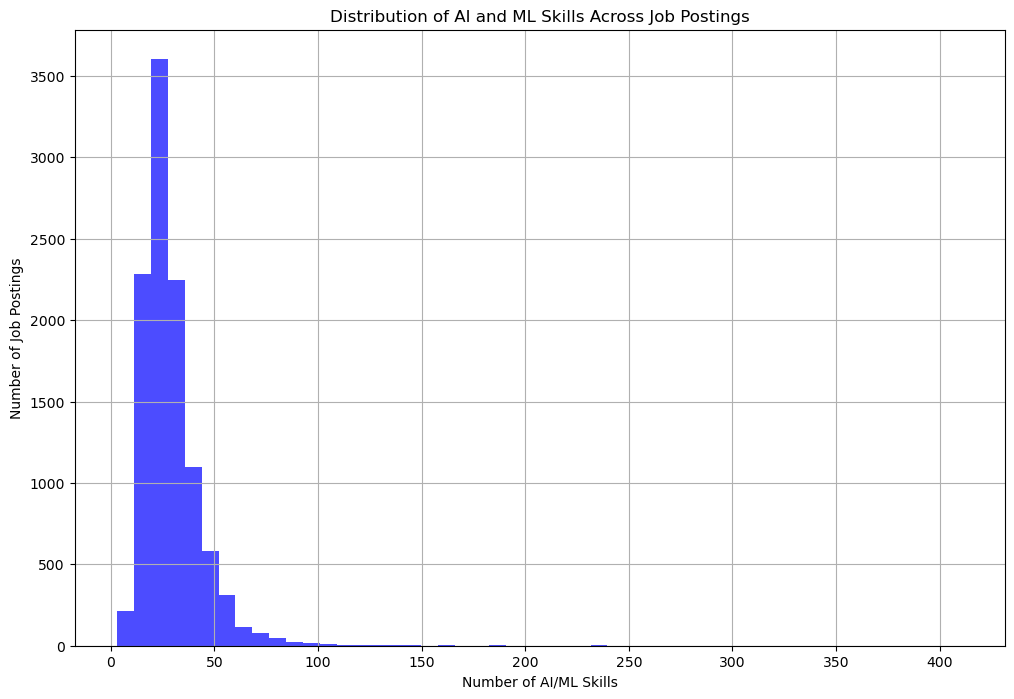

In [109]:
plt.figure(figsize=(12, 8))
ai_ml_jobs['skills_count'].hist(bins=50, color='blue', alpha=0.7)
plt.title('Distribution of AI and ML Skills Across Job Postings')
plt.xlabel('Number of AI/ML Skills')
plt.ylabel('Number of Job Postings')
plt.grid(True)
plt.show()

Plot demand over time

In [113]:
# ai_ml_jobs['last_processed_time'] = pd.to_datetime(ai_ml_jobs['last_processed_time'])
# ai_ml_jobs.set_index('last_processed_time', inplace=True)

# # Monthly demand plot
# ai_ml_jobs.resample('M').size().plot(figsize=(12, 6), color='green')
# plt.title('Monthly AI and ML Job Postings')
# plt.xlabel('Date')
# plt.ylabel('Number of Job Postings')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.show()